In [396]:
!pip install optuna

In [397]:
# EDA for
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
import gc

# Metrics
from sklearn.metrics import (
    mean_squared_error
)

# from tensorflow.keras.metrics import RootMeanSquaredError

# # Models

# import keras_tuner
# from keras import *
# from scikeras.wrappers import KerasRegressor
# from keras import Sequential
# from keras.layers import (
#     Dense, 
#     Dropout,
# )

# from keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    cross_val_score, 
    RepeatedKFold,
    train_test_split,
    GridSearchCV,
    KFold,
)
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

from catboost import *

# Any
import warnings
warnings.filterwarnings('ignore')

In [398]:
class CFG:
    TARGET = 'nivel_y'
    N_FOLDS = 3
    RANDOM_STATE = 87
# MOVE
    # TRAIN_PATH_1 = './data/2024_08_10 16_20_01.csv'
    # TRAIN_PATH_2 = './data/2024_08_10 18_25_52.csv'
    # TRAIN_PATH_3 = './data/2024_08_10 14_31_28.csv'

    # TEST_PATH_1 = './test/test1.csv'
    # TEST_PATH_2 = './test/test2.csv'
    # # TEST_PATH_3 = './test/test3.csv'\
    # # TEST_PATH_4 = './test/test4.csv'
# ENDMOVE

# STABLE DAY1
    TRAIN_PATH = './data/Stable/Day1/2024_09_02_6hz 19_09-20.csv'
    TRAIN_PATH_AIR = './data/Stable/Day1/2024_09_02_6hz 19_09-20_air.csv'

    TEST_PATH_6HZ = './test/Stable/Day1/2024_09_03_6hz 18_08-19_11.csv'
    TEST_PATH_AIR_6HZ = './test/Stable/Day1/2024_09_03_6hz 18_08-19_11_air.csv'
# ENDSTABLE DAY1
# STABLE DAY2
    # TRAIN_PATH_1 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_1.csv'
    # TRAIN_PATH_AIR_1 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_1_air.csv'
    # TRAIN_PATH_2 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_2.csv'
    # TRAIN_PATH_AIR_2 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_2_air.csv'

    # TEST_PATH_1HZ = './test/Stable/Day2/2024_09_03_1hz 16_01-17_35.csv'
    # TEST_PATH_AIR_1HZ = './test/Stable/Day2/2024_09_03_1hz 16_01-17_35_air.csv'
# ENDSTABLE DAY2
# STABLE DAY3
    # TRAIN_PATH = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01.csv'
    # TRAIN_PATH_AIR_1 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_1_air.csv'
    # TRAIN_PATH_AIR_2 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_2_air.csv'
    # TRAIN_PATH_AIR_3 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_3_air.csv'

    # TEST_PATH_03HZ = './test/Stable/Day3/2024_09_03_03hz 19_51-20_35.csv'
    # TEST_PATH_AIR_03HZ = './test/Stable/Day3/2024_09_03_03hz 19_51-20_35_air.csv'
# ENDSTABLE DAY3
# STABLE DAY4
    # TRAIN_PATH_1 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_1.csv'
    # TRAIN_PATH_2 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_2.csv'
    # TRAIN_PATH_AIR_1 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_2_air.csv'

    # TEST_PATH_3HZ_1 = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_1.csv'
    # TEST_PATH_3HZ_2 = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_2.csv'
    # TEST_PATH_AIR_3HZ = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_air.csv'
# ENDSTABLE DAY4


In [399]:
# # MOVE
#     # df_end = pd.read_csv(CFG.TRAIN_PATH_1)
#     # df_start = pd.read_csv(CFG.TRAIN_PATH_2)
#     # df_start_0 = pd.read_csv(CFG.TRAIN_PATH_3)

#     # df_test_1 = pd.read_csv(CFG.TEST_PATH_1)
#     # df_test_2 = pd.read_csv(CFG.TEST_PATH_2)
# # ENDMOVE
# # 1HZ
# df_1 = pd.read_csv(CFG.TRAIN_PATH_1)
# df_air_1 = pd.read_csv(CFG.TRAIN_PATH_AIR_1)
# df_2 = pd.read_csv(CFG.TRAIN_PATH_2)
# df_air_2 = pd.read_csv(CFG.TRAIN_PATH_AIR_2)

# df_test_1 = pd.read_csv(CFG.TEST_PATH_1HZ)
# df_test_air_1 = pd.read_csv(CFG.TEST_PATH_AIR_1HZ)

# temp = pd.concat([df_1,df_2],ignore_index=True)
# temp_air = pd.concat([df_air_1,df_air_2],ignore_index=True)
# # 1HZ

# # 6HZ
df_1 = pd.read_csv(CFG.TRAIN_PATH)
df_air_1 = pd.read_csv(CFG.TRAIN_PATH_AIR)

df_test6 = pd.read_csv(CFG.TEST_PATH_6HZ)
df_test_air6 = pd.read_csv(CFG.TEST_PATH_AIR_6HZ)
# # 6HZ

# # 0.3HZ
# df_1 = pd.read_csv(CFG.TRAIN_PATH)
# df_air_1 = pd.read_csv(CFG.TRAIN_PATH_AIR_1)
# df_air_2 = pd.read_csv(CFG.TRAIN_PATH_AIR_2)
# df_air_3 = pd.read_csv(CFG.TRAIN_PATH_AIR_3)


# df_test3 = pd.read_csv(CFG.TEST_PATH_03HZ)
# df_test_air3 = pd.read_csv(CFG.TEST_PATH_AIR_03HZ)

# temp = pd.concat([df_air_1,df_air_2,df_air_3],ignore_index=True)



# # 3HZ
# df_1 = pd.read_csv(CFG.TRAIN_PATH_1)
# df_2 = pd.read_csv(CFG.TRAIN_PATH_2)
# df_air_1 = pd.read_csv(CFG.TRAIN_PATH_AIR_1)

# df_test_1 = pd.read_csv(CFG.TEST_PATH_3HZ_1)
# df_test_2 = pd.read_csv(CFG.TEST_PATH_3HZ_2)
# df_test_air_1 = pd.read_csv(CFG.TEST_PATH_AIR_3HZ)

# temp = pd.concat([df_1,df_2],ignore_index=True)
# temp_test = pd.concat([df_test_1,df_test_2],ignore_index=True)

In [400]:
# 3HZ
# train = temp[:8000].copy()
# train['air_temp'] = df_air_1['temperature'][:8000]
# test = temp_test[:4700].copy()
# test['air_temp'] = df_test_air_1['temperature'][:4700]



# 1HZ
# train_1 = df_1.copy()
# train_1['air_temp'] = df_air_1['temperature']
# train_2 = df_2.copy()
# train_2['air_temp'] = df_air_2['temperature']

# train = pd.concat([train_1,train_2],ignore_index=True)
# train = train[:5500]

# test = df_test_1[:3000].copy()
# test['air_temp'] = df_test_air_1['temperature'][:3000]

# 6HZ
train = df_1[:4700].copy()
train['air_temp'] = df_air_1['temperature'][:4700]
test = df_test6[:5700].copy()
test['air_temp'] = df_test_air6['temperature'][:5700]

# 0.3HZ
# train = df_1[300:1000].copy()
# train['air_temp'] = temp['temperature'][300:1000]
# train = train.reset_index(drop=True)

# test = df_test3[:1000].copy()
# test['air_temp'] = df_test_air3['temperature'][:1000]



<Axes: >

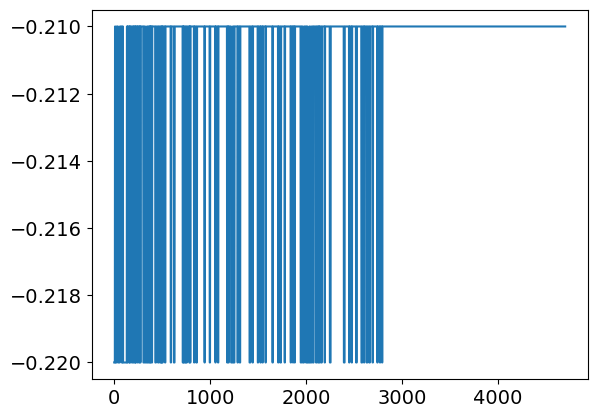

In [401]:
train[CFG.TARGET].plot()

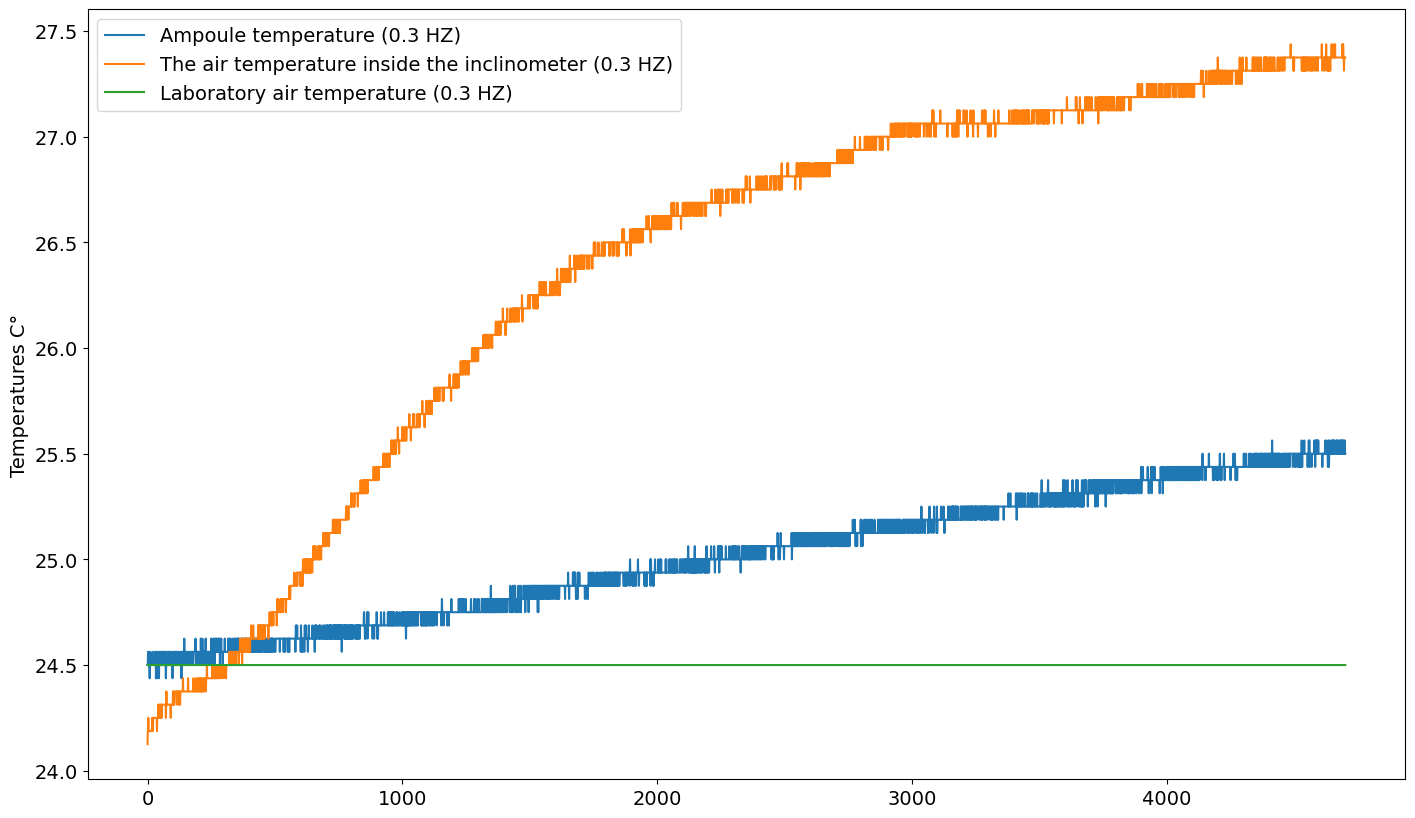

In [402]:
fig,ax = plt.subplots(figsize=(17,10))
plt.rc('font', size=14)          
lns1=ax.plot(train.index,train[['temperature','air_temp', 'nivel_t']])

ax.set_ylabel('Temperatures С°', fontsize=14)

ax.legend(lns1,['Ampoule temperature (0.3 HZ)',
                'The air temperature inside the inclinometer (0.3 HZ)',
                'Laboratory air temperature (0.3 HZ)'],fontsize=14)

plt.show()

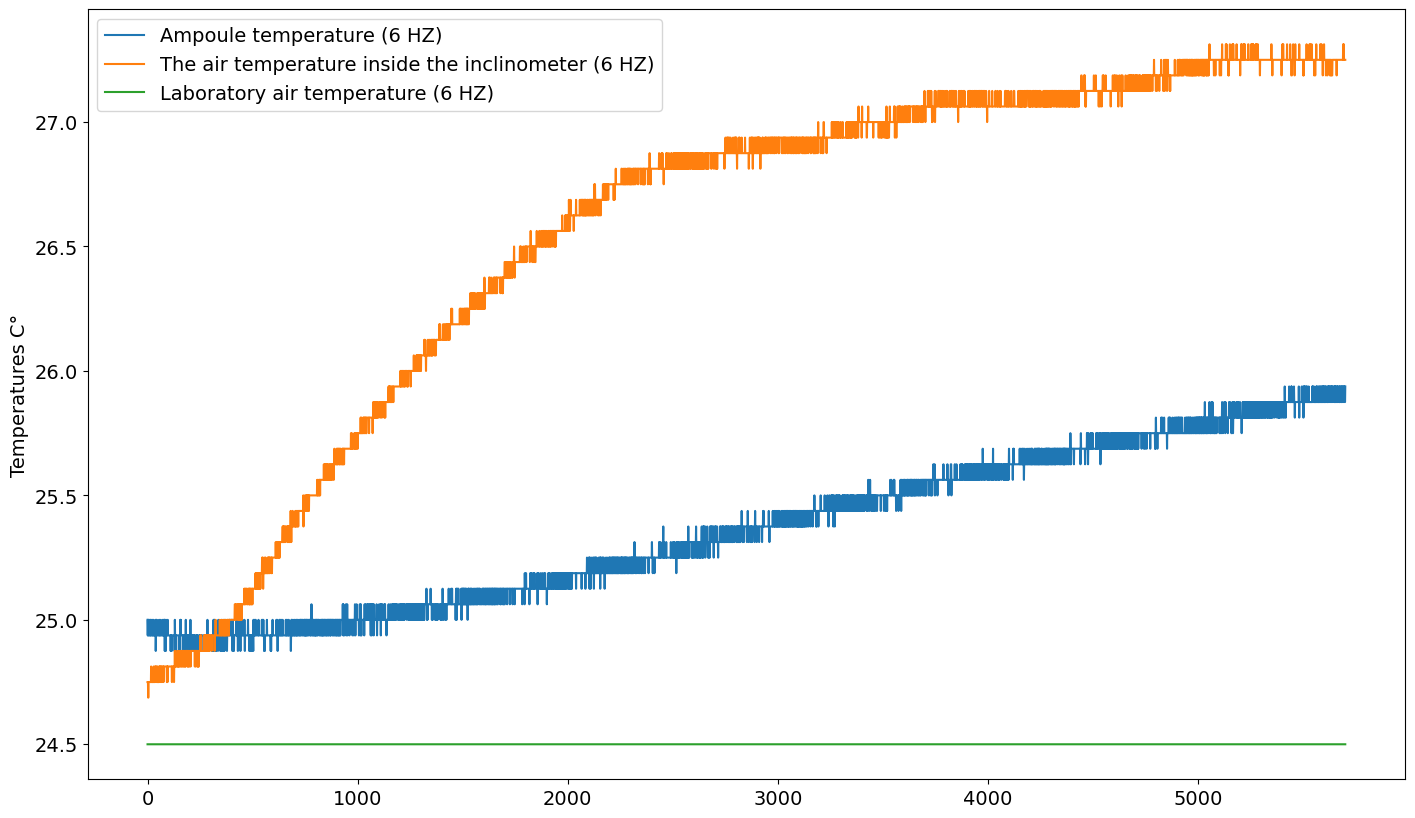

In [403]:
fig,ax = plt.subplots(figsize=(17,10))
plt.rc('font', size=14)          
lns1=ax.plot(test.index,test[['temperature','air_temp', 'nivel_t']])

ax.set_ylabel('Temperatures С°', fontsize=14)

ax.legend(lns1,['Ampoule temperature (6 HZ)',
                'The air temperature inside the inclinometer (6 HZ)',
                'Laboratory air temperature (6 HZ)'],fontsize=14)

plt.show()

<Axes: >

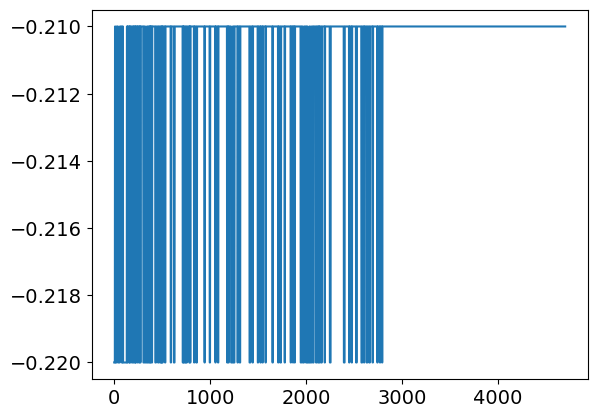

In [404]:
train[CFG.TARGET].plot()

<Axes: >

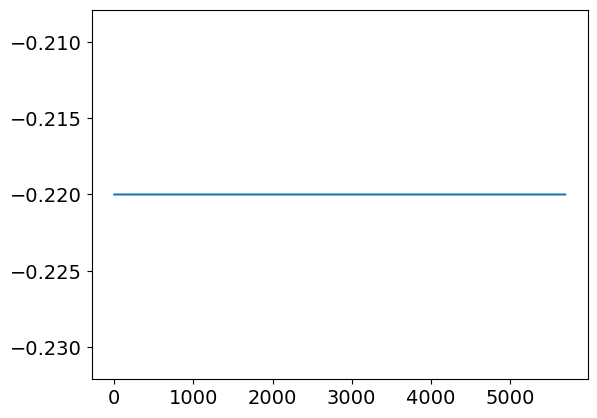

In [405]:
test[CFG.TARGET].plot()

In [406]:
train = train.loc[(train['watch_indicator'] != 'False') &
                (train['watch_indicator'] != 'None')]
train = train.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])

test = test.loc[(test['watch_indicator'] != 'False') &
                (test['watch_indicator'] != 'None')]
test = test.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])


In [407]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
for i in train.columns:
    # if i not in [CFG.TARGET, 'temperature']:
    if i not in [CFG.TARGET, 'temperature', 'air_temp']:
        train[i] = train[i].interpolate()
        test[i] = test[i].interpolate()

In [408]:
def agg_features(df, suffix=''):
    X = pd.DataFrame()    
    X[suffix+"median"] = df.median(axis=1)
    X[suffix+"mean"] = df.mean(axis=1)
    X[suffix+"std"] = df.std(axis=1)
    X[suffix+"max"] = df.max(axis=1)
    X[suffix+"min"] = df.min(axis=1)
    X["length"] = np.sqrt(df['1']**2 - df['center_bubbles_px']**2)
    return X

In [409]:
train = train.join(agg_features(train), how='left')
test = test.join(agg_features(test), how='left')

In [394]:
STEP = 0

for i in train.columns:
    # if i not in [CFG.TARGET, 'temperature']:
    if i not in [CFG.TARGET, 'temperature', 'air_temp']:
        train[i] = train[i].rolling(STEP).median()
        train[i] = train[i][STEP:]
        test[i] = test[i].rolling(STEP).median()
        test[i] = test[i][STEP:]

<Axes: >

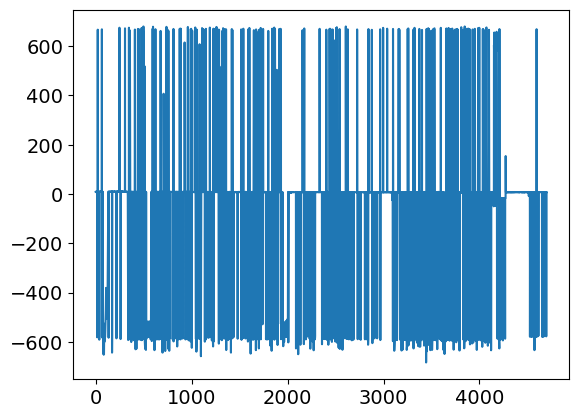

In [410]:
train['center_bubbles_px'].plot()

<Axes: >

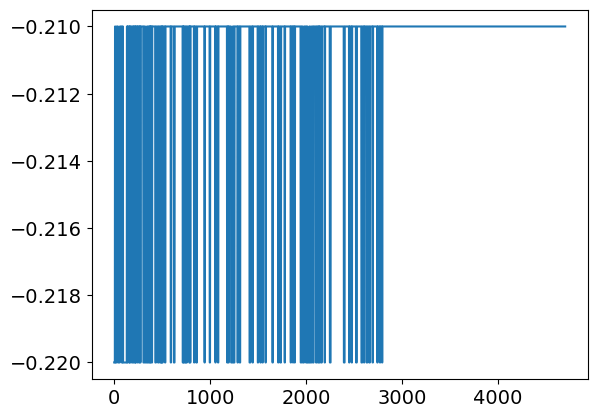

In [411]:
train[CFG.TARGET].plot()

<Axes: >

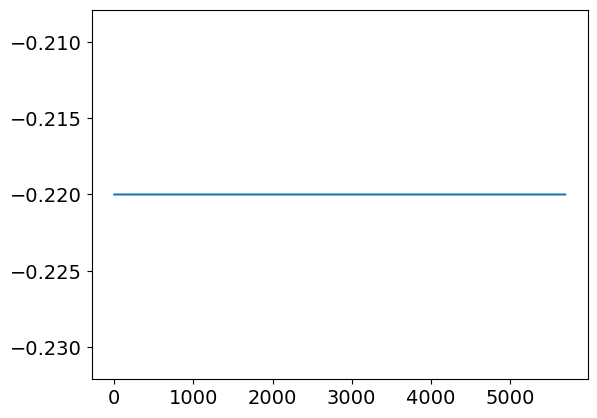

In [412]:
test[CFG.TARGET].plot()

In [413]:
train.dropna(inplace=True)
test.dropna(inplace=True)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [414]:
features = train.drop([CFG.TARGET], axis=1)
target = train[CFG.TARGET]

# Cat

In [415]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [416]:
def build_catboost(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 0.01, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', .1, 1., log=True),
        'random_strength': trial.suggest_float('random_strength', .1, 1., log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', .1, 1., log=True),
        'bootstrap_type':'Bayesian',
        'task_type': 'GPU',
        'loss_function':'RMSE'
    }

    model = CatBoostRegressor(**params, silent=True, random_state=CFG.RANDOM_STATE)
    cv_data = cv(
        Pool(features_train, target_train),
        model.get_params(),
        verbose=False
    )
    return np.min(cv_data['test-RMSE-mean'])

In [417]:
study = optuna.create_study(direction="minimize")
study.optimize(build_catboost, n_trials=10)

[I 2024-09-12 16:28:58,490] A new study created in memory with name: no-name-3bcb62e8-cc46-49c5-9ed6-de8e31fbf452


Training on fold [0/3]
bestTest = 0.0164855872
bestIteration = 999
Training on fold [1/3]
bestTest = 0.01664760349
bestIteration = 999
Training on fold [2/3]


[I 2024-09-12 16:29:19,852] Trial 0 finished with value: 0.01660159413717703 and parameters: {'learning_rate': 0.0025616845879485608, 'depth': 2, 'l2_leaf_reg': 0.10317626592665197, 'random_strength': 0.8561053275041633, 'bagging_temperature': 0.1400129782003218}. Best is trial 0 with value: 0.01660159413717703.


bestTest = 0.01667159172
bestIteration = 999
Training on fold [0/3]
bestTest = 0.003075134472
bestIteration = 969
Training on fold [1/3]
bestTest = 0.003146667079
bestIteration = 999
Training on fold [2/3]


[I 2024-09-12 16:29:48,541] Trial 1 finished with value: 0.003076099350579002 and parameters: {'learning_rate': 0.008159304561764155, 'depth': 3, 'l2_leaf_reg': 0.39014760995776265, 'random_strength': 0.1678657554568174, 'bagging_temperature': 0.7620807816233418}. Best is trial 1 with value: 0.003076099350579002.


bestTest = 0.003006309965
bestIteration = 999
Training on fold [0/3]
bestTest = 0.003417908775
bestIteration = 860
Training on fold [1/3]
bestTest = 0.00404955053
bestIteration = 877
Training on fold [2/3]


[I 2024-09-12 16:30:20,571] Trial 2 finished with value: 0.0035332533285104377 and parameters: {'learning_rate': 0.009963544278261575, 'depth': 6, 'l2_leaf_reg': 0.11179602874158183, 'random_strength': 0.3986271311577733, 'bagging_temperature': 0.103610825336723}. Best is trial 1 with value: 0.003076099350579002.


bestTest = 0.003132107151
bestIteration = 884
Training on fold [0/3]
bestTest = 0.1267953698
bestIteration = 999
Training on fold [1/3]
bestTest = 0.1270056846
bestIteration = 999
Training on fold [2/3]


[I 2024-09-12 16:30:59,114] Trial 3 finished with value: 0.1269213559994576 and parameters: {'learning_rate': 0.0005111963536056539, 'depth': 7, 'l2_leaf_reg': 0.15347377279505695, 'random_strength': 0.16726498464202746, 'bagging_temperature': 0.5407763144681916}. Best is trial 1 with value: 0.003076099350579002.


bestTest = 0.1269630135
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2104231275
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2105524354
bestIteration = 999
Training on fold [2/3]


[I 2024-09-12 16:31:25,752] Trial 4 finished with value: 0.21050971454015688 and parameters: {'learning_rate': 3.872520706325288e-06, 'depth': 4, 'l2_leaf_reg': 0.14162252968462283, 'random_strength': 0.41896498109628777, 'bagging_temperature': 0.4077561669488331}. Best is trial 1 with value: 0.003076099350579002.


bestTest = 0.2105535807
bestIteration = 999
Training on fold [0/3]
bestTest = 0.0528671571
bestIteration = 999
Training on fold [1/3]
bestTest = 0.05323829619
bestIteration = 999
Training on fold [2/3]


[I 2024-09-12 16:32:52,528] Trial 5 finished with value: 0.05306579242890727 and parameters: {'learning_rate': 0.0013915612494883255, 'depth': 10, 'l2_leaf_reg': 0.3145592283091668, 'random_strength': 0.6081220684106525, 'bagging_temperature': 0.974673131406716}. Best is trial 1 with value: 0.003076099350579002.


bestTest = 0.053091924
bestIteration = 999
Training on fold [0/3]
bestTest = 0.003025150965
bestIteration = 999
Training on fold [1/3]
bestTest = 0.003077314865
bestIteration = 999
Training on fold [2/3]


[I 2024-09-12 16:33:14,498] Trial 6 finished with value: 0.0030448263714212033 and parameters: {'learning_rate': 0.00677562884862651, 'depth': 2, 'l2_leaf_reg': 0.825262324782087, 'random_strength': 0.26791001231485695, 'bagging_temperature': 0.4147109663959374}. Best is trial 6 with value: 0.0030448263714212033.


bestTest = 0.003032013284
bestIteration = 999
Training on fold [0/3]
bestTest = 0.1836313967
bestIteration = 999
Training on fold [1/3]
bestTest = 0.1837924913
bestIteration = 999
Training on fold [2/3]


[I 2024-09-12 16:33:50,727] Trial 7 finished with value: 0.1837370874357064 and parameters: {'learning_rate': 0.00014051529908402043, 'depth': 7, 'l2_leaf_reg': 0.6504209886132126, 'random_strength': 0.21727711894255747, 'bagging_temperature': 0.11905691988448691}. Best is trial 6 with value: 0.0030448263714212033.


bestTest = 0.1837873743
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2004009357
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2005434517
bestIteration = 999
Training on fold [2/3]


[I 2024-09-12 16:35:20,258] Trial 8 finished with value: 0.2004951669449143 and parameters: {'learning_rate': 5.2827087818904385e-05, 'depth': 10, 'l2_leaf_reg': 0.3104191633017281, 'random_strength': 0.6804068003442717, 'bagging_temperature': 0.32504973442875473}. Best is trial 6 with value: 0.0030448263714212033.


bestTest = 0.2005411134
bestIteration = 999
Training on fold [0/3]
bestTest = 0.05178447826
bestIteration = 999
Training on fold [1/3]
bestTest = 0.05195386316
bestIteration = 999
Training on fold [2/3]


[I 2024-09-12 16:35:40,671] Trial 9 finished with value: 0.05190110972783968 and parameters: {'learning_rate': 0.0014065197392273269, 'depth': 2, 'l2_leaf_reg': 0.5407646787548979, 'random_strength': 0.5210201561420602, 'bagging_temperature': 0.2714146893470046}. Best is trial 6 with value: 0.0030448263714212033.


bestTest = 0.05196498776
bestIteration = 999


In [419]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.00677562884862651, 'depth': 2, 'l2_leaf_reg': 0.825262324782087, 'random_strength': 0.26791001231485695, 'bagging_temperature': 0.4147109663959374}
Best RMSE: 0.0030448263714212033


# CB
- Best hyperparameters: {'learning_rate': 0.006699123931378129, 'depth': 2, 'l2_leaf_reg': 0.19572812514881727, 'random_strength': 0.34729027098244525, 'bagging_temperature': 0.12879624935096712}
- Best RMSE: 0.003129836768837352

In [420]:
rmses = []
preds = []
skf = KFold(n_splits=20)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train[CFG.TARGET])):
    print(f'### Fold {fold+1} Training ###')

    X_train = train.loc[train_idx, [c for c in train.columns if c not in [CFG.TARGET]]]
    y_train = train.loc[train_idx, CFG.TARGET]
    X_valid = train.loc[valid_idx, X_train.columns]
    y_valid = train.loc[valid_idx, CFG.TARGET]
    X_test = test[X_train.columns]



    X_train_pool = Pool(X_train, y_train)
    X_valid_pool = Pool(X_valid, y_valid)
    X_test_pool = Pool(X_test)


    model = CatBoostRegressor(
        loss_function='RMSE',
        learning_rate=0.00677562884862651,
        iterations=10000,
        depth=2,
        l2_leaf_reg=0.825262324782087,
        random_strength=0.26791001231485695,
        bagging_temperature=0.4147109663959374,
        bootstrap_type='Bayesian',
        task_type='GPU',
        random_seed=CFG.RANDOM_STATE,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=500, early_stopping_rounds=200)

    pred_valid = model.predict(X_valid_pool)
    preds.append(model.predict(X_test_pool))

    rmse = mean_squared_error(y_valid, pred_valid)**.5
    rmses.append(rmse)
    
    del X_train, y_train, X_valid, y_valid, X_test
    gc.collect()

    print(f'Fold {fold+1} RMSE: {rmse:.5f}\n')

print(f'\nOverall RMSE: {np.median(rmse):.5f} +/- {np.std(rmse):.5f}')

### Fold 1 Training ###
0:	learn: 0.0031375	test: 0.0066366	best: 0.0066366 (0)	total: 8.08ms	remaining: 1m 20s
500:	learn: 0.0028806	test: 0.0050026	best: 0.0050006 (499)	total: 3.45s	remaining: 1m 5s
1000:	learn: 0.0028232	test: 0.0048869	best: 0.0048849 (995)	total: 6.96s	remaining: 1m 2s
bestTest = 0.004878897845
bestIteration = 1042
Shrink model to first 1043 iterations.
Fold 1 RMSE: 0.00488

### Fold 2 Training ###
0:	learn: 0.0032564	test: 0.0053649	best: 0.0053649 (0)	total: 7.59ms	remaining: 1m 15s
500:	learn: 0.0028721	test: 0.0048137	best: 0.0048112 (418)	total: 3.44s	remaining: 1m 5s
bestTest = 0.004811233502
bestIteration = 418
Shrink model to first 419 iterations.
Fold 2 RMSE: 0.00481

### Fold 3 Training ###
0:	learn: 0.0033898	test: 0.0034247	best: 0.0034247 (0)	total: 7.01ms	remaining: 1m 10s
bestTest = 0.003424355545
bestIteration = 2
Shrink model to first 3 iterations.
Fold 3 RMSE: 0.00342

### Fold 4 Training ###
0:	learn: 0.0033481	test: 0.0041358	best: 0.0041358 (

In [421]:
pd.DataFrame(rmses).median()

0    0.003252
dtype: float64

In [422]:
C0 = -.015

In [423]:
from scipy import stats

res = stats.linregress(features['temperature'], features['center_bubbles_px'])

print(res)

LinregressResult(slope=18.332153973837713, intercept=-572.4691728348641, rvalue=0.023402557675534657, pvalue=0.12000169997441096, stderr=11.788654742975238, intercept_stderr=294.9356816984557)


<Axes: >

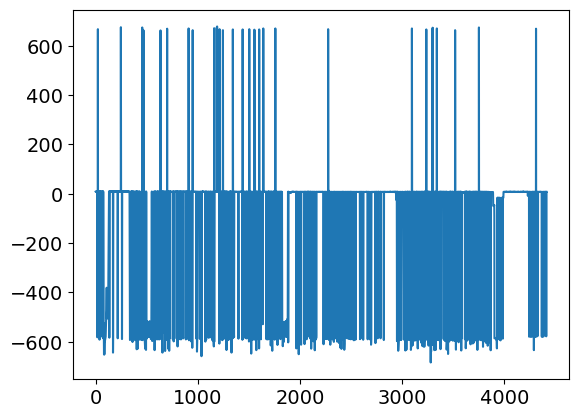

In [424]:
features['center_bubbles_px'].plot()

In [433]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(features, target)

pred_l = reg.predict(test.drop(columns=CFG.TARGET))

np.sqrt(mean_squared_error(test[CFG.TARGET], pred_l))

1.7707856482509705e-11

In [434]:
dif_l = test[CFG.TARGET] - (pred_l)
dif_l.mean()

-1.5274055189262867e-12

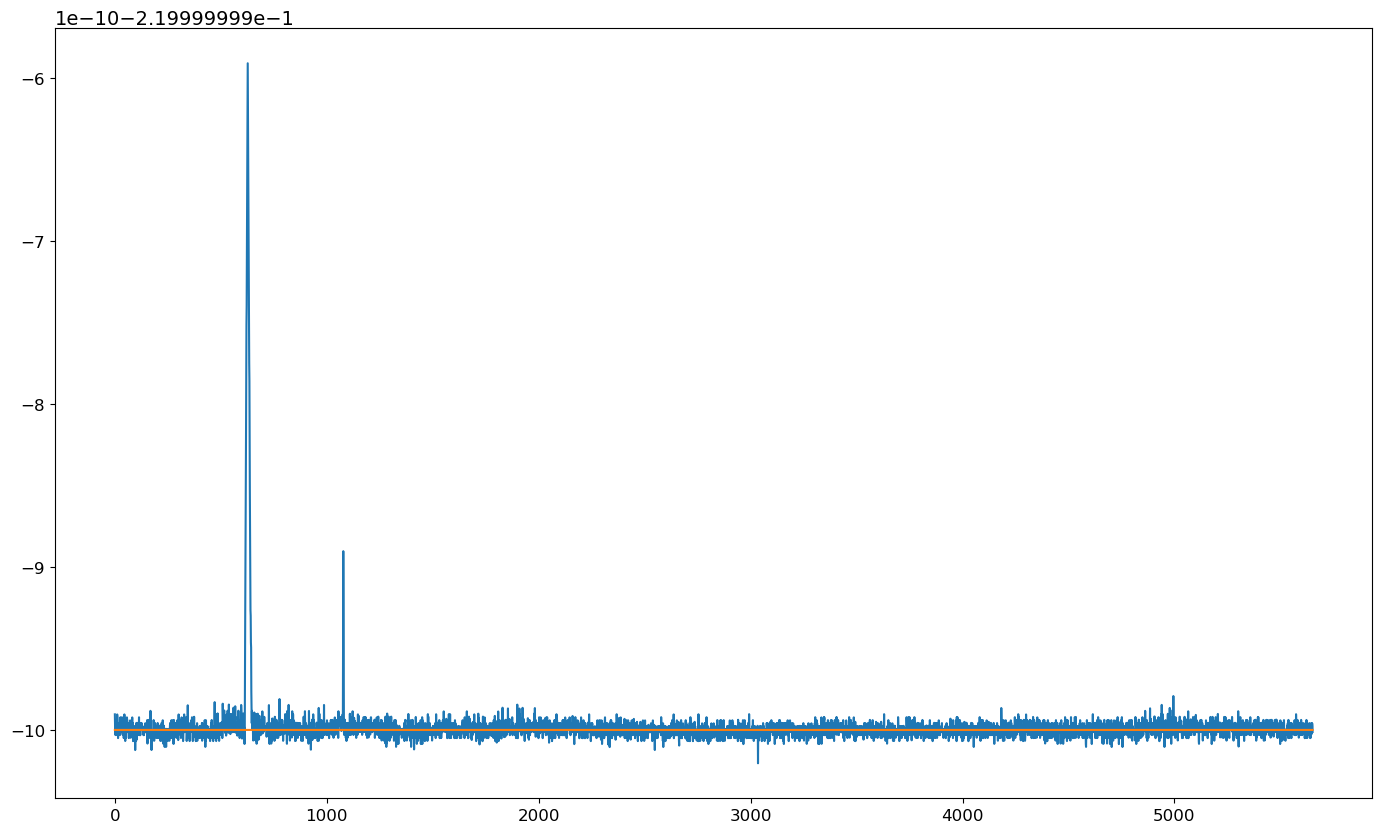

In [432]:
pd.DataFrame(pred_l).plot(figsize=(17,10),legend=False,fontsize=12);test[CFG.TARGET].plot();

In [143]:
# model = CatBoostRegressor()
# model.load_model('model_temp_stable_6')

In [435]:
r = model.predict(test[train.columns])

In [436]:
np.sqrt(mean_squared_error(test[CFG.TARGET], r))

0.009081883750298876

In [377]:
C0 = -0.015

In [282]:
C0 = (test[CFG.TARGET] - r).mean()

In [283]:
C0

-0.008778327547874987

In [437]:
np.sqrt(mean_squared_error(test[CFG.TARGET], r))

0.0060072016700521555

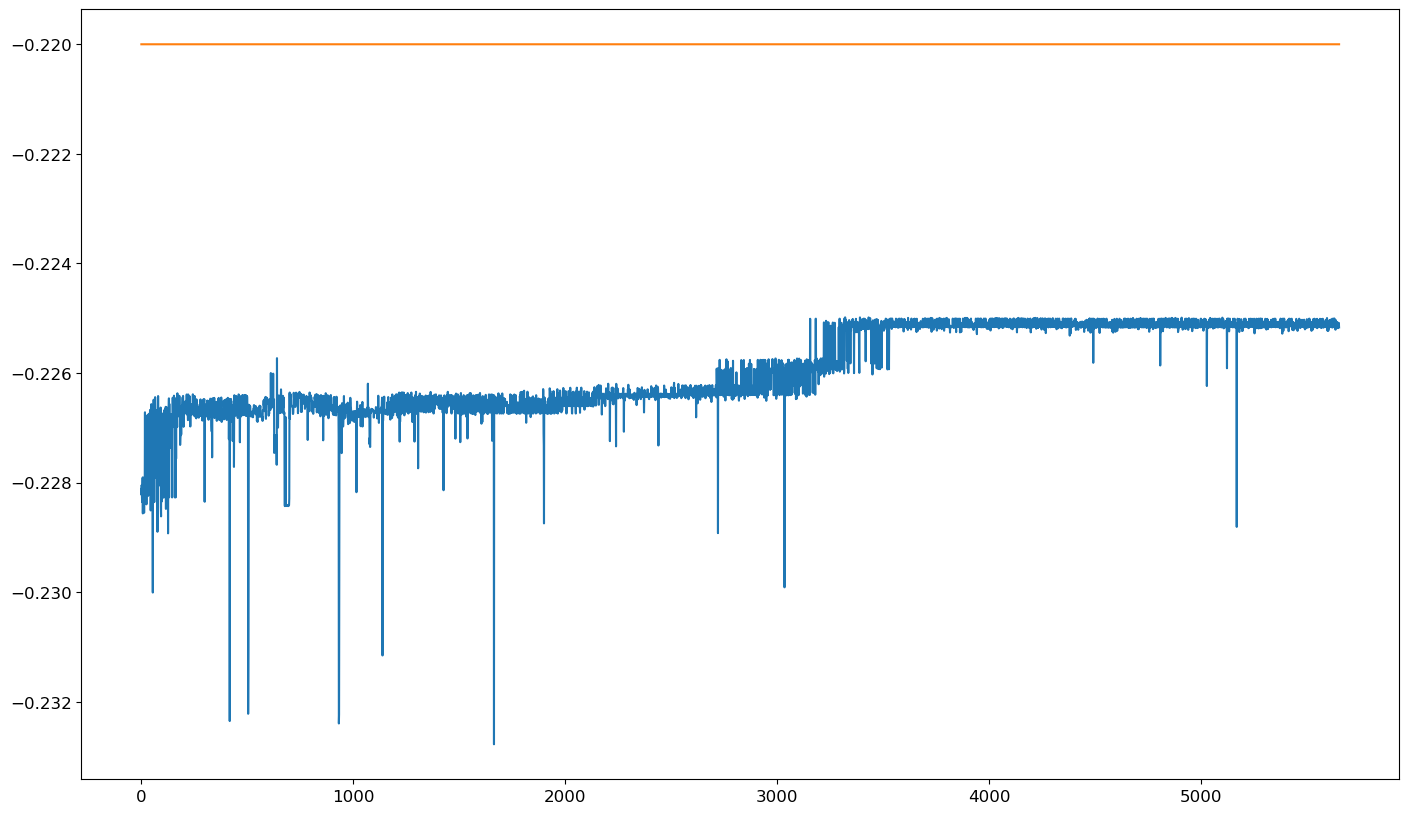

In [431]:
pd.DataFrame(r+C0).plot(figsize=(17,10),legend=False,fontsize=12);test[CFG.TARGET].plot();

<Axes: >

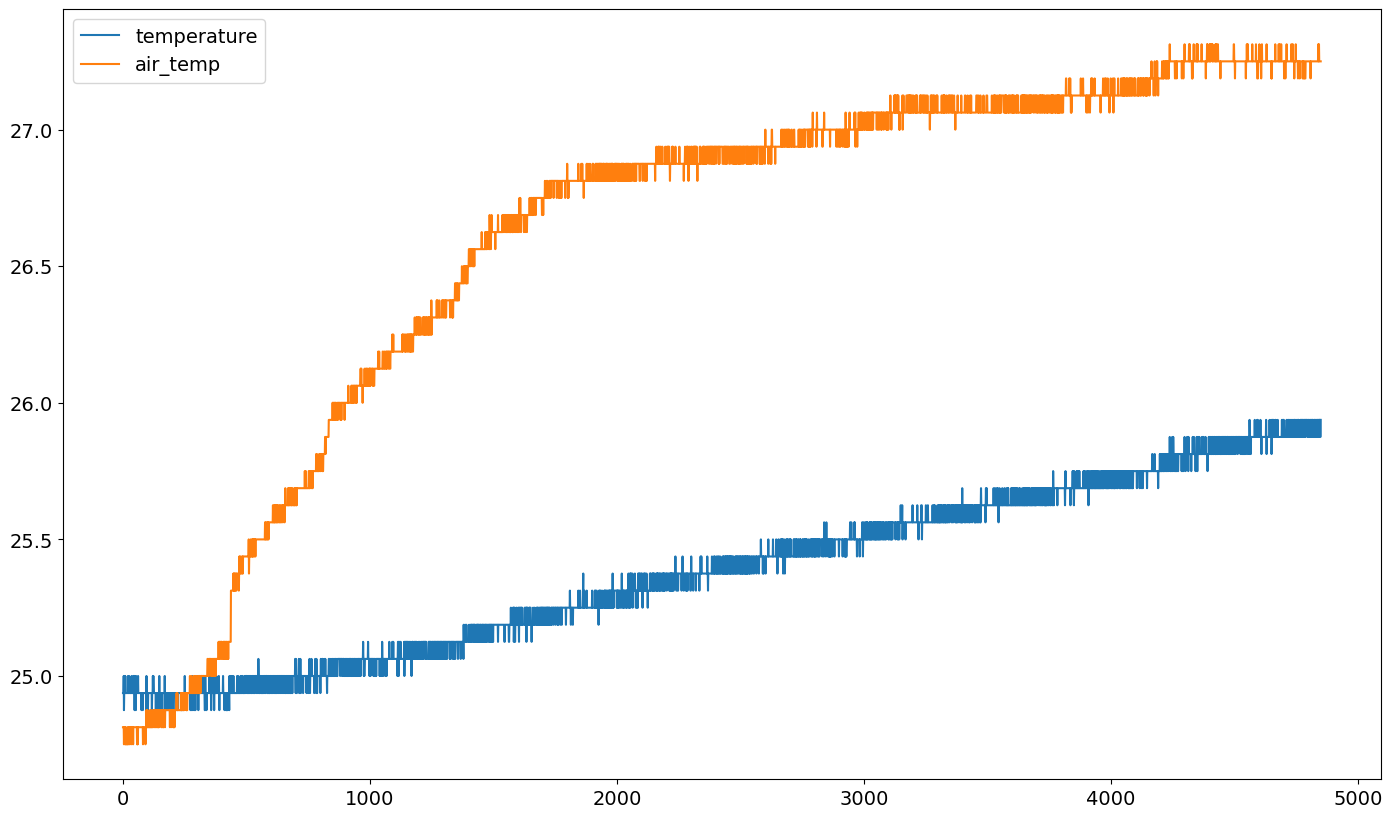

In [294]:
test['temperature'].plot(legend=True,figsize=(17,10));test['air_temp'].plot(legend=True)

In [379]:
dif = test[CFG.TARGET] - (r+C0)

In [380]:
dif.mean()

0.006151033503321275

<Axes: >

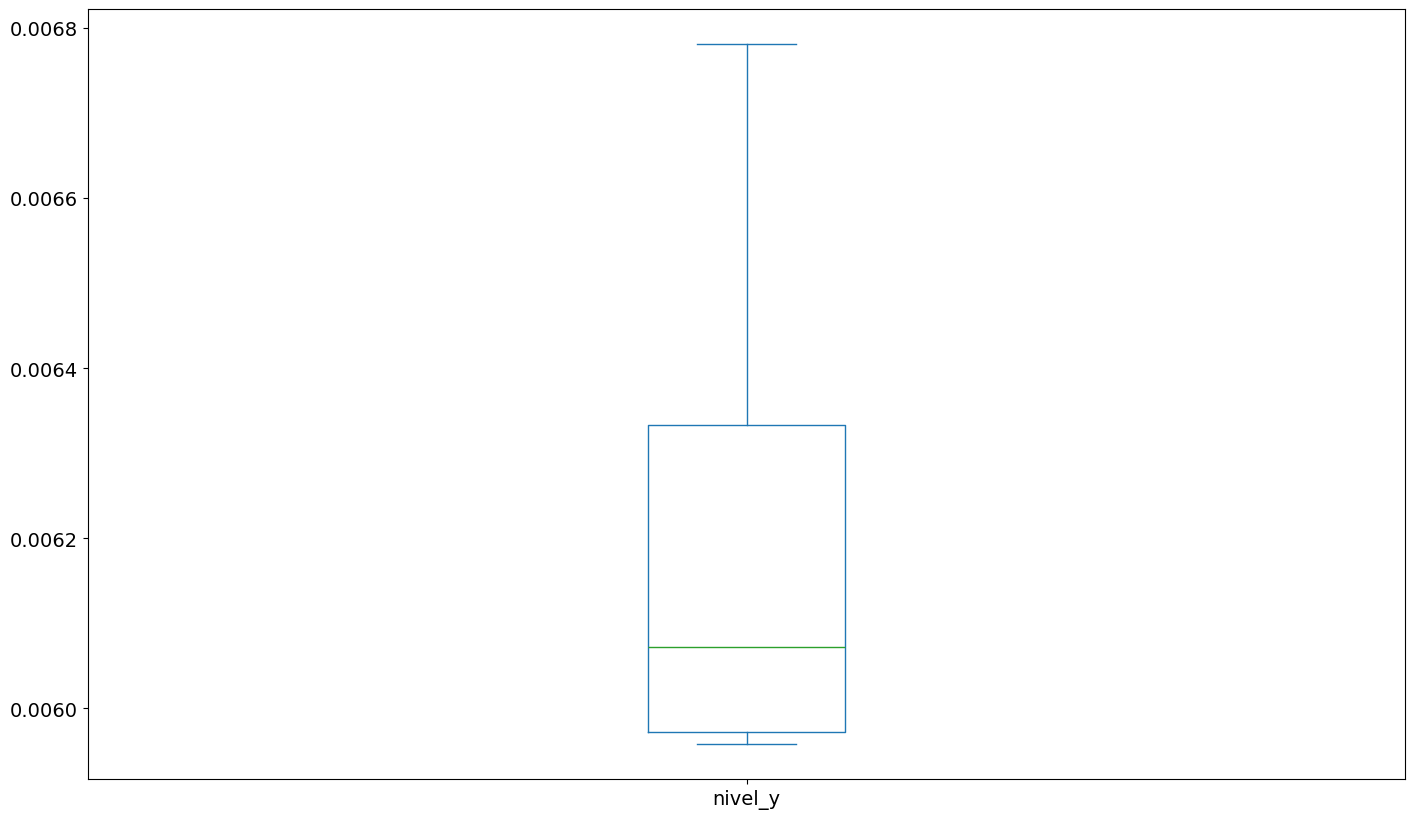

In [381]:
dif.plot(figsize=(17,10),kind='box')

In [438]:
model.save_model('model_temp_stable_non_6')

# NN

In [176]:
features

,center_bubbles_px,temperature,1,2,3,4,5,6,7,8,...,98,99,100,air_temp,median,mean,std,max,min,length
0,0.0,24.5000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.1250,0.00,0.000000,0.000000,0.0,0.0,0.000000
1,0.0,24.5000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.1875,0.00,0.000000,0.000000,0.0,0.0,0.000000
2,0.0,24.5625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.1875,0.00,0.000000,0.000000,0.0,0.0,0.000000
3,0.0,24.5000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.2500,0.00,0.000000,0.000000,0.0,0.0,0.000000
4,9.0,24.5000,-173.0,-173.0,-172.0,-172.0,-171.0,-170.0,-170.0,-168.0,...,58.0,64.0,65.0,24.1875,-130.75,-99.259928,75.171977,65.0,-173.0,172.765737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4865,8.0,25.5625,-173.0,-173.0,-172.0,-172.0,-171.0,-167.0,-167.0,-166.0,...,105.0,106.0,106.0,27.4375,-130.50,-93.838558,83.503742,106.0,-173.0,172.814930
4866,7.5,25.5625,-173.0,-173.0,-172.0,-172.0,-171.0,-169.0,-168.0,-167.0,...,102.0,106.0,106.0,27.4375,-130.50,-94.516442,83.343909,106.0,-173.0,172.837351
4867,7.5,25.5625,-173.0,-173.0,-172.0,-172.0,-171.0,-169.0,-167.0,-166.0,...,105.0,107.0,108.0,27.4375,-130.50,-94.516442,83.343909,108.0,-173.0,172.837351
4868,7.5,25.5625,-173.0,-173.0,-172.0,-172.0,-171.0,-170.0,-168.0,-167.0,...,106.0,111.0,112.0,27.4375,-128.50,-89.237596,87.291004,112.0,-173.0,172.837351


In [124]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [125]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [126]:
def build_model():
    model_nn = Sequential()
    model_nn.add(Dense(32, activation='tanh'))
    model_nn.add(Dense(1))
    model_nn.compile(optimizer=Adam(), 
                    loss='mean_squared_error', 
                    metrics=[RootMeanSquaredError()])
    return model_nn

In [ ]:
model_nn = build_model()

model_nn.fit(
    features_train,
    target_train,
    epochs=100
)

In [19]:
def build_neural_network(hp):    
    model = Sequential()
    model.add(layers.Flatten())
    for i in range(hp.Int("num_layers", 1, 8)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=128, max_value=1024, step=64),
                activation=hp.Choice("activation", ["tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.35))
    model.add(layers.Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=[RootMeanSquaredError()]
    )
    return model

In [20]:
build_neural_network(keras_tuner.HyperParameters())

In [21]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_neural_network,
    objective=keras_tuner.Objective('val_root_mean_squared_error', 'min'),
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
)

In [22]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [23]:
X_train, X_val, y_train, y_val = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [24]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Trial 5 Complete [00h 09m 02s]
val_root_mean_squared_error: 0.020136764893929165

Best val_root_mean_squared_error So Far: 0.020136764893929165
Total elapsed time: 00h 21m 15s


In [25]:
best_NN = build_neural_network(tuner.get_best_hyperparameters()[0])

In [26]:
callback = EarlyStopping(monitor='loss', patience=100)

In [27]:
best_NN.fit(
    X_train,  
    y_train,
    epochs=10000,
    callbacks=[callback]
)

Epoch 1/10000


333/333 [==============================] - 1s 3ms/step - loss: 0.0445 - root_mean_squared_error: 0.2110
Epoch 2/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771
Epoch 3/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0055 - root_mean_squared_error: 0.0741
Epoch 4/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726
Epoch 5/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0050 - root_mean_squared_error: 0.0708
Epoch 6/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697
Epoch 7/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0046 - root_mean_squared_error: 0.0676
Epoch 8/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0043 - root_mean_squared_error: 0.0659
Epoch 9/10000
333/333 [==============================] - 1s 3ms/step -

In [28]:
ynew = best_NN.predict(features)
class_probabilities = np.hstack((1-ynew, ynew))

444/444 [==============================] - 1s 1ms/step


In [189]:
target

0      -0.01
1      -0.01
2      -0.01
3      -0.01
4      -0.01
        ... 
7663    1.50
7664    1.50
7665    1.50
7666    1.50
7667    1.50
Name: nivel_y, Length: 7668, dtype: float64

In [190]:
pred = pd.DataFrame(ynew)

In [191]:
np.sqrt(mean_squared_error(target, pred))

0.026182164995101342

<Axes: >

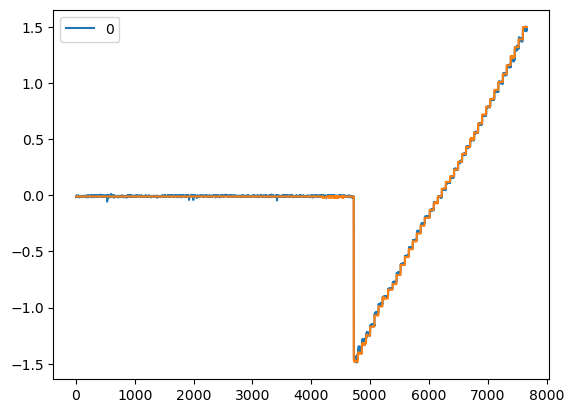

In [192]:
pred.plot(); target.plot()

In [193]:
dif = target - pred[0]

In [194]:
dif.std()

0.025986164382474093

In [195]:
dif.mean()

-0.0032113998970169882

# Test NN

In [198]:
test_df = pd.read_csv('./test/test1.csv')

In [199]:
test_df = test_df.loc[(test_df['watch_indicator'] != 'False') &
(test_df['watch_indicator'] != 'None')]
test_df = test_df.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])

In [200]:
test_df = test_df.reset_index(drop=True)
for i in test_df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        test_df[i] = test_df[i].interpolate()

In [201]:
test_df = test_df.join(agg_features(test_df), how='left')

In [202]:
for i in test_df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        print(i)
        test_df[i] = test_df[i].rolling(5).median()
        test_df[i].fillna(0, inplace=True)

center_bubbles_px
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
median
mean
std
max
min


In [203]:
features = test_df.drop([CFG.TARGET],axis=1)
target = test_df[CFG.TARGET]

In [204]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [205]:
pred = best_NN.predict(features)

19/19 [==============================] - 0s 833us/step


In [206]:
pred = pd.DataFrame(pred)

In [207]:
np.sqrt(mean_squared_error(target, pred))

0.3847204189031395

<Axes: >

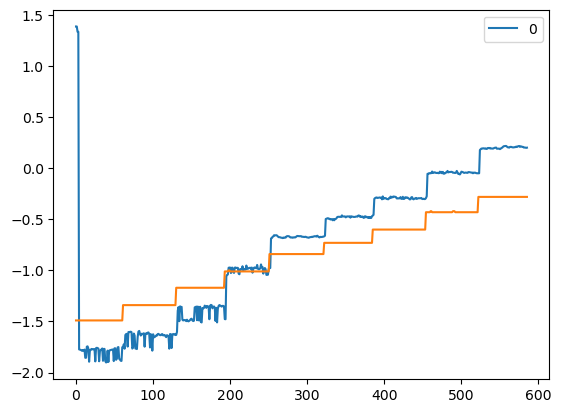

In [208]:
pd.DataFrame(pred).plot();target.plot()